In [23]:
import pandas as pd

In [24]:
df=pd.read_csv('btc_1h.csv')

In [25]:
df

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...,...
35659,2022-01-31 01:30:00,37512.37,37740.00,37351.63,37684.45,1037.922560
35660,2022-01-31 02:30:00,37684.45,37762.60,37492.25,37729.00,874.060520
35661,2022-01-31 03:30:00,37729.00,37855.54,37625.41,37785.78,734.658550
35662,2022-01-31 04:30:00,37785.78,38230.00,37778.46,37881.76,1728.811800


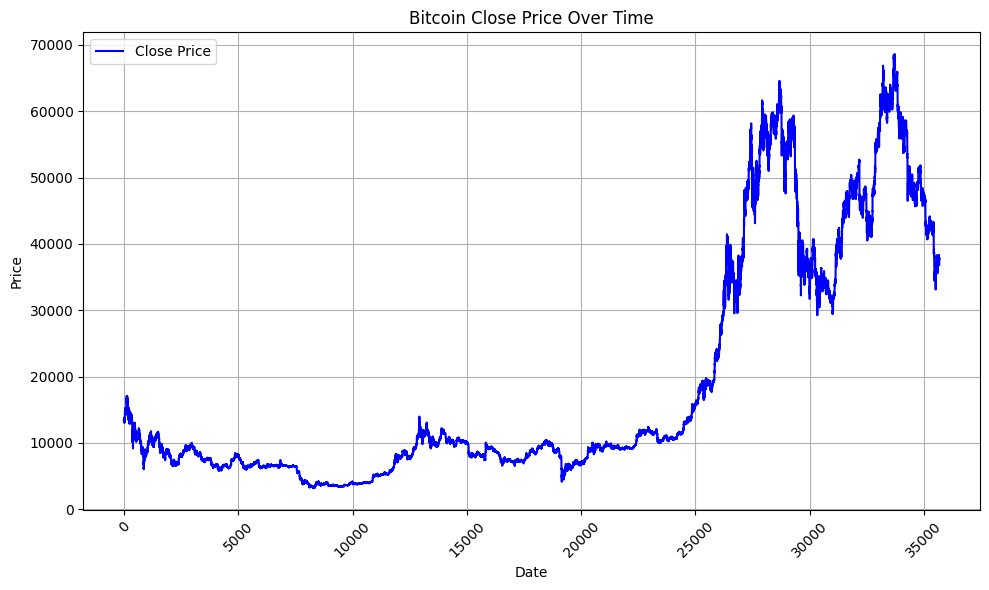

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  

plt.plot(df.index, df['close'], label='Close Price', color='blue')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Close Price Over Time')

plt.xticks(rotation=45)

plt.grid(True)

plt.legend()  
plt.tight_layout()  
plt.show()


In [27]:
window_size_param=20
threshold_param=100

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from ta.volatility import AverageTrueRange
data = df.copy()

data['MA'] = data['close'].rolling(window=window_size_param).mean()

data['price_diff'] = data['close'].diff()  
data['target'] = (data['price_diff'] > threshold_param).astype(int)  
data['ATR'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()

for lag in range(1, 5):
    data[f'lag_{lag}_ATR'] = data['ATR'].shift(lag)

X = data[['MA', 'ATR', 'lag_1_ATR', 'lag_2_ATR', 'lag_3_ATR', 'lag_4_ATR']]  
Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
import numpy as np

missing_indices_train = np.isnan(X_train_scaled).any(axis=1)
X_train_cleaned = X_train_scaled[~missing_indices_train]
Y_train_cleaned = Y_train[~missing_indices_train]

missing_indices_test = np.isnan(X_test_scaled).any(axis=1)
X_test_cleaned = X_test_scaled[~missing_indices_test]
Y_test_cleaned = Y_test[~missing_indices_test]


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cleaned, Y_train_cleaned)
Y_pred = clf.predict(X_test_cleaned)

classification_rep = classification_report(Y_test_cleaned, Y_pred)
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      3052
           1       0.43      0.18      0.25       512

    accuracy                           0.85      3564
   macro avg       0.65      0.57      0.58      3564
weighted avg       0.81      0.85      0.82      3564



In [31]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train_cleaned, Y_train_cleaned)
Y_pred_xgb = xgb_clf.predict(X_test_cleaned)
classification_rep_xgb = classification_report(Y_test_cleaned, Y_pred_xgb)
print("XGBoost Classification Report:\n", classification_rep_xgb)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.91      3052
           1       0.38      0.12      0.18       512

    accuracy                           0.85      3564
   macro avg       0.62      0.54      0.55      3564
weighted avg       0.80      0.85      0.81      3564



In [32]:
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_clf = RandomForestClassifier(random_state=42)
xgb_clf = xgb.XGBClassifier(random_state=42)

X_cleaned = X.fillna(X.mean())

rf_cv_results = cross_validate(rf_clf, X_cleaned, Y, cv=skf, scoring=('accuracy', 'precision', 'recall', 'f1'), return_train_score=False)
print("Random Forest Cross-Validation Results:")
print("Accuracy:", rf_cv_results['test_accuracy'])
print("Precision:", rf_cv_results['test_precision'])
print("Recall:", rf_cv_results['test_recall'])
print("F1-score:", rf_cv_results['test_f1'])

xgb_cv_results = cross_validate(xgb_clf, X_cleaned, Y, cv=skf, scoring=('accuracy', 'precision', 'recall', 'f1'), return_train_score=False)
print("\nXGBoost Cross-Validation Results:")
print("Accuracy:", xgb_cv_results['test_accuracy'])
print("Precision:", xgb_cv_results['test_precision'])
print("Recall:", xgb_cv_results['test_recall'])
print("F1-score:", xgb_cv_results['test_f1'])


Random Forest Cross-Validation Results:
Accuracy: [0.85560073 0.86008692 0.85546054 0.85307725 0.85712283]
Precision: [0.41708543 0.45641026 0.41561713 0.40632054 0.43436754]
Recall: [0.17219917 0.1846473  0.17116183 0.1865285  0.18879668]
F1-score: [0.24375918 0.26292467 0.24246877 0.25568182 0.26319595]

XGBoost Cross-Validation Results:
Accuracy: [0.85770363 0.85812421 0.8561615  0.85742324 0.8589456 ]
Precision: [0.42776204 0.43370166 0.40718563 0.42857143 0.42808219]
Recall: [0.156639   0.16286307 0.14107884 0.16165803 0.12966805]
F1-score: [0.22930904 0.23680241 0.20955316 0.23476298 0.19904459]


In [33]:
#Prefering RF Model,class1 is buying condition
from joblib import dump
dump(clf, 'saved_rf_model.joblib')


['saved_rf_model.joblib']